### Program to read Datawell hexadecimal .HVA file
JW 03/19
Hexadecimal format described in DWTP 2.1 p.19

In [1]:
%matplotlib inline

import array as arr
import binascii
import colorama
import itertools
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats
#import statistics as s
import sys
import tkinter as tk

sys.path.append('../Modules')

import HVA_tools as ht
import wave_plotting_tools as wpt

from colorama import Fore, Back, Style
from datetime import datetime, time, timedelta
from itertools import count # izip for maximum efficiency
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path, PureWindowsPath
from scipy import fftpack, signal
from scipy.signal import tukey
from scipy.stats import norm,rayleigh,skew,kurtosis
from statistics import mean
from tkinter import filedialog
from tkinter import *

Sample_frequency = "global"
Sample_rate = "global"
Sample_frequency = 2.56
Sample_rate = 1. / Sample_frequency

In [2]:
def get_file():
    """
    Gets an input file

    This module uses tkinter routines to provide graphical display of files,
    allowing user to select an input file to the program.

    Args:
        root.filename (str): Name of input data file to be read.
        
    Returns:
        root.filename (str): Input data file to be read.
   """    

# Select input file
    root = Tk()
    root.filename = filedialog.askopenfilename(initialdir = "C:\QGHL\Wave_data",\
    title = "Select HVA file",filetypes = (("HVA files","*.hva"),("all files","*.*")))
    root.destroy()

    return(root.filename)

In [3]:
def finished():
#    print('Into finished')
    master.quit()
    master.destroy()
    raise SystemExit

Reading data from  <_io.TextIOWrapper name='/home/waldroj/data/Bris/09/brisbane_4183}2019-09-13T00h00Z.hva' mode='r' encoding='UTF-8'>
Building Displacement data array
Building Packet data array
Of  108797  records:
     108797  records were received properly from the buoy
     0  records were damaged but have been repaired successfully
     0  records were damaged beyond repair and the data should be discarded
                 Hs= 0.95 Ti=10.03 Te= 9.10 T1= 6.39 Tz= 5.05 T3= 3.28 Tc= 2.40 Tp=10.53
                 Hmax= 1.39 THmax= 8.91 Tmax=13.35 HTmax= 1.14 Hsrms= 0.84 Nw= 286 Nc= 602
---------------------------------------------------
2019-09-13 10:00 Number of samples recorded on buoy  =  4608
                 Number of samples received from HF  =  3934
                 Number of segments recorded on buoy =    17
ALERT: Transmission Error -  337  vectors lost from this record!
ALERT: Possible spikes in the data at times: [1203.78 1204.17 1204.56]
                 Hsig=0.96  Hrms=0

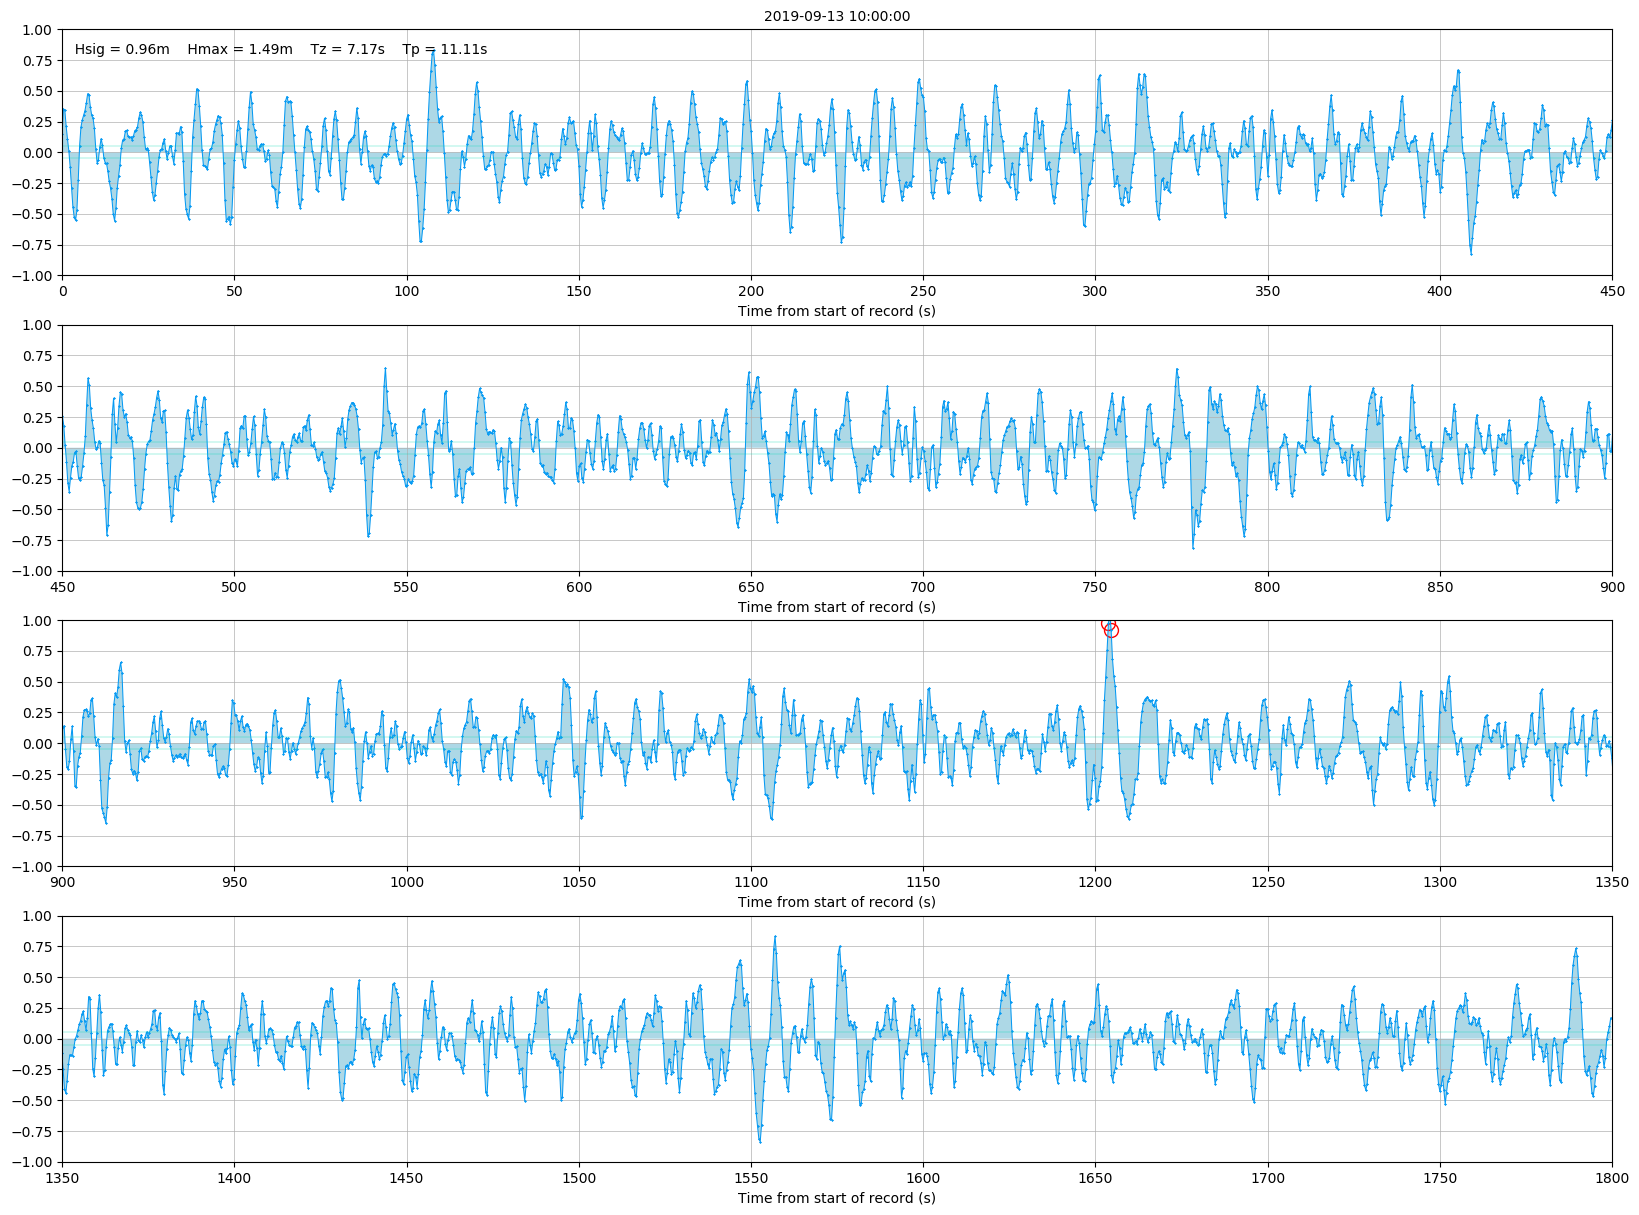

                 Hs= 0.97 Ti=10.07 Te= 9.23 T1= 6.62 Tz= 5.20 T3= 3.30 Tc= 2.35 Tp=11.11
                 Hmax= 1.67 THmax=10.71 Tmax=13.36 HTmax= 0.88 Hsrms= 0.87 Nw= 279 Nc= 621
---------------------------------------------------
2019-09-13 10:30 Number of samples recorded on buoy  =  4608
                 Number of samples received from HF  =  4608
                 Number of segments recorded on buoy =    17
ALERT: Possible spikes in the data at times: [ 536.44  536.84  537.23 1446.8  1450.31 1450.71 1460.08]
                 Hsig=0.96  Hrms=0.68  Hmax=1.51  Tz=7.26  THsig=8.61  Tp=13.33 Tmax=18.46 Wave Num.=238     
                 Hm0=0.96  Hrms=0.68  T01=6.97  T02=5.41  Tp=13.33


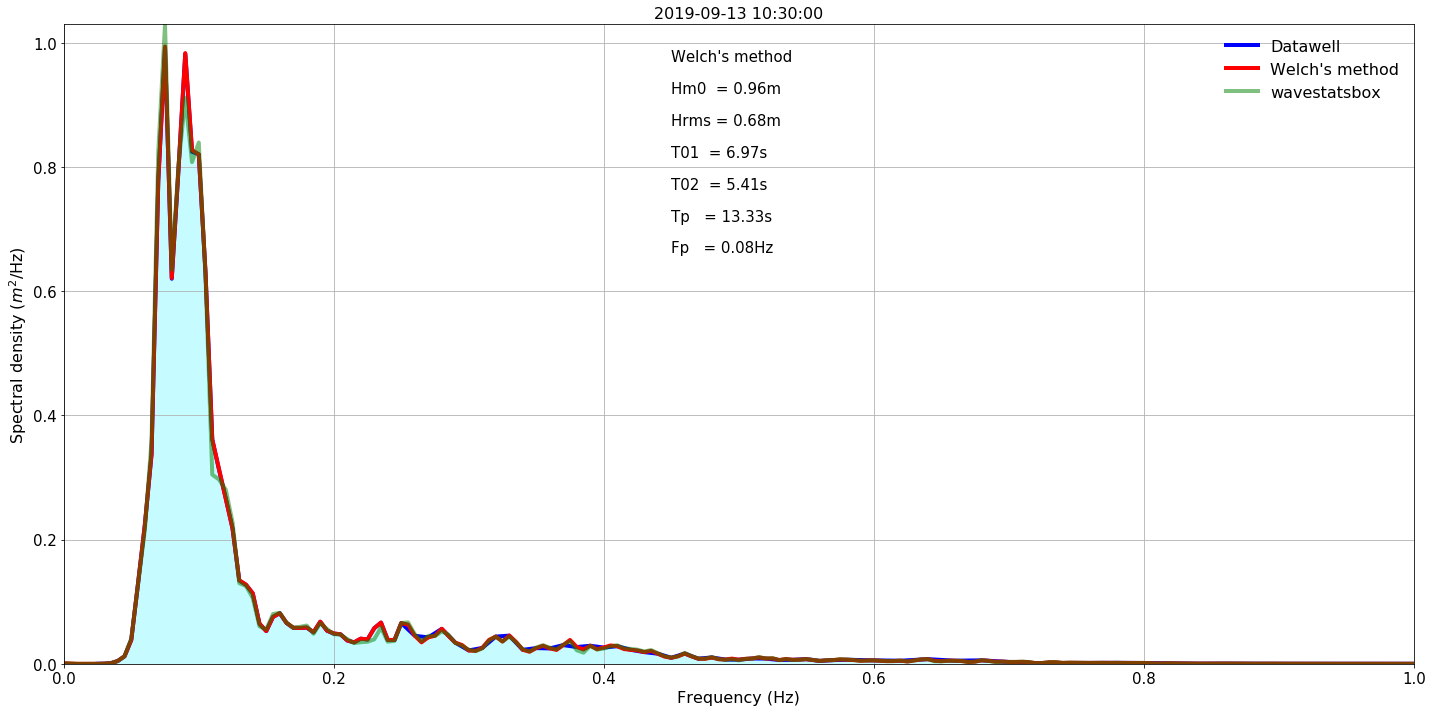

                 Hs= 0.96 Ti=10.46 Te= 9.67 T1= 7.00 Tz= 5.43 T3= 3.36 Tc= 2.34 Tp=13.33
                 Hmax= 1.71 THmax=10.05 Tmax=14.53 HTmax= 0.57 Hsrms= 0.88 Nw= 256 Nc= 617
---------------------------------------------------
2019-09-13 11:00 Number of samples recorded on buoy  =  4608
                 Number of samples received from HF  =  4608
                 Number of segments recorded on buoy =    17
ALERT: Possible spikes in the data at times: [ 864.25  921.29  921.68  922.08 1198.7  1199.09 1199.48 1199.87]
                 Hsig=0.90  Hrms=0.64  Hmax=1.33  Tz=7.07  THsig=10.04 Tp=10.00 Tmax=16.83 Wave Num.=250     
                 Hm0=0.93  Hrms=0.66  T01=7.07  T02=5.58  Tp=10.00
ALERT: Possible spikes in the Heave data at times: [ 864.25  921.29  921.68  922.08 1198.7  1199.09 1199.48 1199.87]
ALERT:  1  Heave values missing from file!
ALERT: Possible spikes in the North data at times: [ 196.92  197.31 1711.7  1712.09 1712.48]
ALERT:  1  North values missing from file!
A

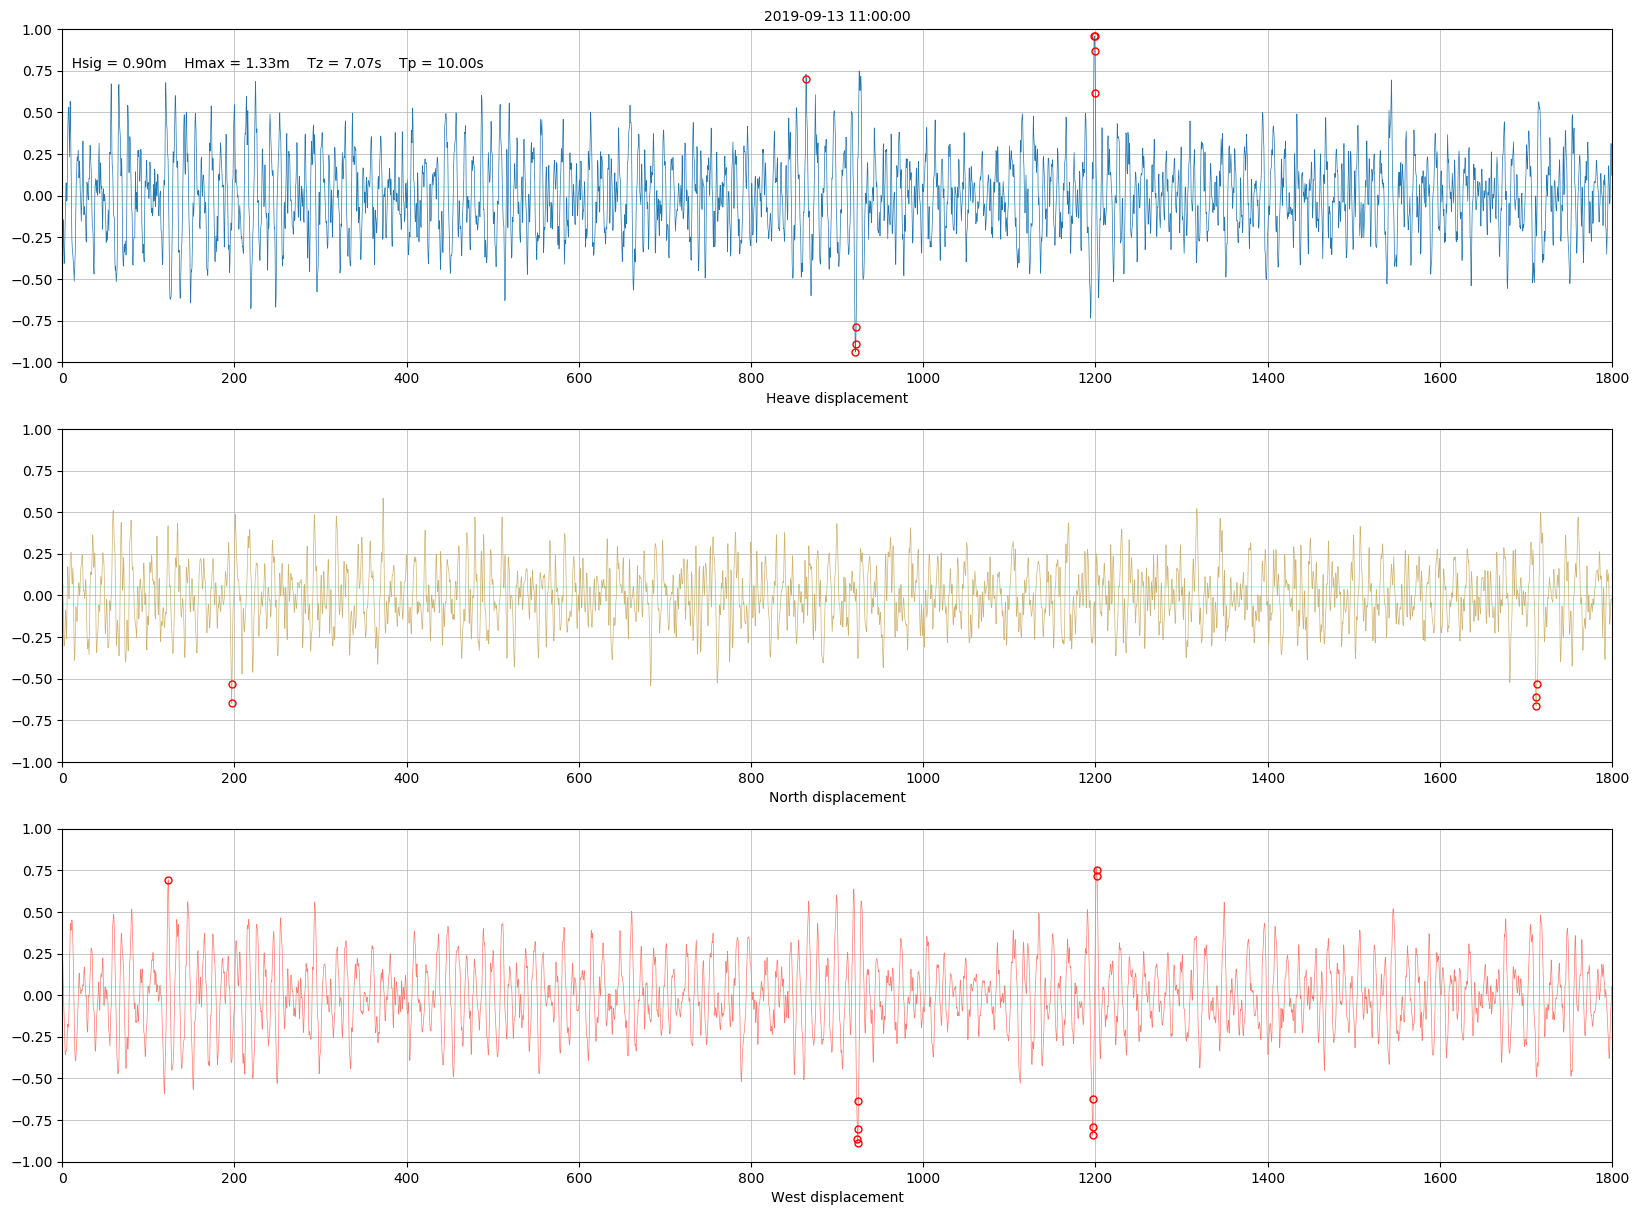

SystemExit: 

In [5]:
###################################################################    
###################################################################
#     START MAIN PROGRAM - Read_HVA
###################################################################
###################################################################

# Make Jupyter Notebook window wider
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

master = Tk()
master.title("Mk4 HVA Files")
colorama.init()
# Get name of input PRIM file
Input_HVA_File = get_file()

date_str = Input_HVA_File.split('}')[1].split('.')[0]
Start_time = datetime.strptime(date_str, "%Y-%m-%dT%Hh%MZ") + timedelta(hours=10)
Next_time = Start_time; F20_time = Start_time; F23_time = datetime.now()

# Open file
f = open(Input_HVA_File)

# Read data from the Binary file into a DF based on the structure in the DT
print('Reading data from ',f)
#data = pd.DataFrame(np.fromfile(f, BB1))

data = pd.read_csv(f, names=['Cycle_counter','Displacements_List','Packet_List'], header=None)

# Build the HVA format
Cycle_DF = [int(str(data['Cycle_counter'][c]),base=16) for c in range(len(data['Cycle_counter']))]
Displacements_DF = data.Displacements_List
Packet_data_DF = data.Packet_List

# Transform DF's into Lists
Displacements_List = []; Packet_List = []
print('Building Displacement data array')
Displacements_List = Displacements_DF.tolist()
Packet_List = Packet_data_DF.tolist()

Packet_data = []
print('Building Packet data array')
for val in Packet_List:
    Packet_data.append(val[1:3])
    Packet_data.append(val[3:5])
    Packet_data.append(val[5:7])
    
# Locate occurrences of records that have been damaged beyond repair - Refer to DWTP 2.1 p.20
Good_data = [i for i,x in enumerate([x[0:1]for x in Displacements_List]) if x == '-']
Repaired_data = [i for i,x in enumerate([x[0:1]for x in Displacements_List]) if x == '=']
Bad_data = [i for i,x in enumerate([x[0:1]for x in Displacements_List]) if x == '!']

print('Of ',len(Displacements_List),' records:')
print('    ',len(Good_data),' records were received properly from the buoy')
print('    ',len(Repaired_data),' records were damaged but have been repaired successfully')
print('    ',len(Bad_data),' records were damaged beyond repair and the data should be discarded')

# Locate occurrences of 0x7E's in Packet_data - Refer to DWTP 2.1.2 p.21
##print('Locating occurrences of 0x7E in Packet data')
Valu_0x7E_List = [i for i, j in enumerate(Packet_data) if j == '7E']

# Get the bytes between respective '7E' values - ignoring where consecutive '7E' values exist
fk = []; s_tilde = []; dirn = []; spread = []
Position_old = 0
for __ in range(len(Valu_0x7E_List)-1):
    start = Valu_0x7E_List[__]+1; end = Valu_0x7E_List[__+1]
    if end-start > 1:
        Decoded = Packet_data[start:end]
        
        Found_7D = [m for m, n in enumerate(Decoded) if n == '7D']        # Locate '7D' in packet

        for p in range(len(Found_7D)):
            XOred = hex(int(Decoded[Found_7D[p]+1],16)^int('20',16))      # X'Or the byte after '7D'
            Decoded[Found_7D[p]+1] = XOred[2:].upper()

        for p in range(len(Found_7D)-1,-1,-1): 
            del Decoded[Found_7D[p]]                                      # Remove this '7D' from the packet
            
        Message_Id = Decoded[0][0]+Decoded[1]; CRC_4_Checksum = Decoded[0][1]
        
###        print(Message_Id)

        if (Message_Id == 'F25'): 
            F25_time,Hs,Ti,Te,T1,Tz,T3,Tc,Tp = ht.Do_F25(Decoded)            # Decode Directional Spectral Parameters message
            
        if (Message_Id == 'F26'): 
            F26_time,Hmax,THmax,Tmax,HTmax,Hsrms,Nw,Nc = ht.Do_F26(Decoded)  # Decode online upcrossing wave statistics message                    
    
        if (Message_Id == 'F20'):
            F20_time,s_tilde,Smax,No_of_segments = ht.Do_F20(Decoded)                       # Decode Heave spectrum message
            fk = ht.calc_frequencies()

        if (Message_Id == 'F21'): 
            F21_time,dirn,spread = ht.Do_F21(Decoded)            # Decode Primary Directional Spectrum Message 

        if (Message_Id == 'F23'): 
            F23_time,Match_vector,Sample_number,Hn_1_sign,Nn_1_sign,Wn_1_sign,Hn_sign,Nn_sign,Wn_sign = ht.Do_F23(Decoded)          # Decode Spectrum synchronisation message

        if (Message_Id == 'F29'): ht.Do_F29(Decoded)
            
        if (F20_time == F23_time):
            
            if (F20_time >= Next_time):   # Indicates at least one record has been missed
                Position = [i for i, j in zip(count(), Displacements_List) if j == '-'+Match_vector]
                if len(Position) > 0:     # Get the WL's, and Displacements in North and West
                    
                    print('{:20s}{:5.2f}{:4s}{:5.2f}{:4s}{:5.2f}{:4s}{:5.2f}{:4s}{:5.2f}{:4s}{:5.2f}{:4s}{:5.2f}{:4s}{:5.2f}' \
                        .format('                 Hs=',Hs,' Ti=',Ti,' Te=',Te,' T1=',T1,' Tz=',Tz,' T3=',T3,' Tc=',Tc,' Tp=',Tp))

                    print('{:22s}{:5.2f}{:7s}{:5.2f}{:6s}{:5.2f}{:7s}{:5.2f}{:7s}{:5.2f}{:4s}{:4d}{:4s}{:4d}' \
                        .format('                 Hmax=',Hmax,' THmax=',THmax,' Tmax=',Tmax,' HTmax=',HTmax,' Hsrms=',Hsrms,' Nw=',Nw,' Nc=',Nc))
                    
                    Status = []; heave = []; north = []; west = []
                    Status,heave,north,west = ht.Get_Displacements(Position,Sample_number, 
                                                                          Displacements_List,Status,heave,north,west)
                    heave = ht.Calc_MWL(heave)           # Apply a correction for Mean Water Level
                    Record_time = F20_time  # Pass Record_time to the Calc_parameters cell

                    Match_Vector_Difference = int(Position[0]) - Position_old # Get the number of vectors actually received on shore
                    print('---------------------------------------------------')
                    print('{:%Y-%m-%d %H:%M}{:22s}{:5d}'.format(Record_time,' Number of samples recorded on buoy  = ',Sample_number))
                    print('{:38s}{:5d}'.format('                 Number of samples received from HF  = ',Match_Vector_Difference * 2))
                    print('{:38s}{:5d}'.format('                 Number of segments recorded on buoy = ',No_of_segments))

# Check for Transmission errors                    
                    Position_Bad = Position_old
                    if Match_Vector_Difference != 2304:
                        vector_diff = 2304 - Match_Vector_Difference
                        if vector_diff > 0:
                            print('ALERT: Transmission Error - ',vector_diff,' vectors lost from this record!')
                            Bad_Displacements_List = ht.Fill_Gaps(Displacements_List,Position,Position_Bad,Cycle_DF)
                    Position_old = int(Position[0])

# Check for consecutive values the same - to detect an accelerometer fault.
# Suggested value for this check is 11 (4.3s)
                    heave_around = np.around(heave,decimals=2)
                    num_of_consecutive_values_same = max(len(list(v)) for g,v in itertools.groupby(heave_around))
                    if num_of_consecutive_values_same > 4:
                        print('Warning: There are ',num_of_consecutive_values_same,' consecutive points with the same value!')
                    
                    Next_time = F20_time + timedelta(seconds=4608/2.56)
                                             
                    f_Mk4 = ht.calc_frequencies()    # calculate frequency values for the Mk4 wave buoy
                    f2,Pden2,Tp2 = ht.calc_spectral_parameters(heave,Sample_frequency)

                    Below,Hmean,Hsig,Hmax,Tz,THsig,Tp2,Tmax,waves,spikes = ht.Do_time_domain(heave,F20_time,Tp2,Displacements_List,Position)
                    Hm0,Hrms,T01,T02,Tp,Fp = ht.get_parameters_Mk4(f_Mk4,s_tilde,F20_time)
                    ht.Do_error_checks(heave,Hsig,Hmax,Hrms,Hm0,THsig,T02,Tz,Tp,Tmax)
                    
                    ################################################### Could probably move this to more effecient location
                    import datetime as dt
                    import pandas as pd 

                    Datawell_time = dt.datetime(1970,1,1,0,0,0)

                    Time = [(F20_time-Datawell_time).total_seconds()+i/2.56 for i in range(len(heave))]

                    # intialise data of lists. 
                    data = {'Time':Time, 'Date/Time':F20_time, 'Heave':heave, 'North':north, 'West':west} 

                    # Create DataFrame 
                    df = pd.DataFrame(data) 

                    # Drop 'Date/Time' column from DataFrame 
                    df = df.drop(['Date/Time'], axis = 1)

                    import wavestatsbox
                    data = wavestatsbox.displacements(df[0:4608])
                    f,Pxx_den = data.spectra()
                    ###################################################            
                                                   
                MyButton1 = Button(master, text='Plot waves',font=('Sans','12','bold'),height=2,width=30, 
                                   command=lambda:wpt.Plot_heave(heave,Below,Hsig,Hmax,Tz,Tp2,F20_time,spikes))
                MyButton1.grid(row=0, column=0)

                MyButton2 = Button(master, text='Heave-North-West',font=('Sans','12','bold'),height=2,width=30, 
                                   command=lambda:wpt.Plot_heave_north_west(heave,north,west,Hsig,Hmax,Tz,Tp2,Record_time,spikes))
                MyButton2.grid(row=1, column=0)

                MyButton3 = Button(master, text='XYZ Time Series Plot',font=('Sans','12','bold'),height=2,width=30,\
                       command=lambda:wpt.Do_XYZ_plot(heave,north,west,F20_time,Sample_frequency))
                MyButton3.grid(row=2, column=0)
                
                MyButton4 = Button(master, text='Spectra',font=('Sans','12','bold'),height=2,width=30, 
                                   command=lambda:wpt.Plot_spectra(f_Mk4,s_tilde,f2,Pden2,f,Pxx_den,F20_time,Hm0,Hrms,T01,T02,Tp,Fp))
                MyButton4.grid(row=3, column=0)

                MyButton5 = Button(master, text='Histogram',font=('Sans','12','bold'),height=2,width=30, 
                                   command=lambda:wpt.Do_Histogram(heave,F20_time))
                MyButton5.grid(row=4, column=0)
                
                MyButton6 = Button(master, text='XYZ Hist Plot',font=('Sans','12','bold'),height=2,width=30,\
                                   command=lambda:wpt.Do_XYZ_Hist(heave,north,west,str(F20_time)))
                MyButton6.grid(row=5, column=0)

                MyButton7 = Button(master, text='Velocity Plot',font=('Sans','12','bold'),height=2,width=30, 
                                   command=lambda:wpt.Plot_velocities(heave))
                MyButton7.grid(row=6, column=0)
                
                MyButton8 = Button(master, text='Rayleigh',font=('Sans','12','bold'),height=2,width=30, 
                                   command=lambda:wpt.Do_Rayleigh(waves,F20_time,Hsig,Hrms,Hmax))
                MyButton8.grid(row=7, column=0)
                
                MyButton9 = Button(master, text='2d Plot',font=('Sans','12','bold'),height=2,width=30, 
                                   command=lambda:wpt.Do_polar(heave,north,west,F20_time,Sample_frequency))
                MyButton9.grid(row=8, column=0)
                
                MyButton10 = Button(master, text='3d Plot',font=('Sans','12','bold'),height=2,width=30, 
                                   command=lambda:wpt.Do_3d(heave,north,west,F20_time,Sample_frequency))
                MyButton10.grid(row=9, column=0)
                
                MyButton11 = Button(master, text='Plot Direction',font=('Sans','12','bold'),height=2,width=30,\
                       command=lambda:wpt.Do_Plot_Direction(Start_time,dirn,spread))
                MyButton11.grid(row=10, column=0)
                
                MyButton12 = Button(master, text='Box Plot',font=('Sans','12','bold'),height=2,width=30,\
                       command=lambda:wpt.Do_Box_plot(heave,north,west,F20_time,Sample_frequency))
                MyButton12.grid(row=11, column=0)

                MyButton13 = Button(master, text='Continue',font=('Sans','12','bold'),height=2,width=30, 
                                   command=master.quit)
                MyButton13.grid(row=12, column=0)

                MyButton14 = Button(master, text='QUIT',font=('Sans','12','bold'),fg='red',height=2,width=30, 
                                    command=lambda:finished())
                MyButton14.grid(row=13, column=0)

                master.mainloop()
                    
###################################################################    
###################################################################
#     END MAIN PROGRAM - Read_HVA
###################################################################
###################################################################

In [ ]:
Valu_0x7E_List

## Investigate methods of calculating spectra

In [ ]:
## Plot_spectra(f_Mk4,s_tilde,f2,Pden2,F20_time,Hm0,Hrms,T01,T02,Tp,Fp))
import datetime as dt
import pandas as pd 

Datawell_time = dt.datetime(1970,1,1,0,0,0)

Time = [(F20_time-Datawell_time).total_seconds()+i/Sample_frequency for i in range(len(heave))]
  
# intialise data of lists. 
data = {'Time':Time, 'Date/Time':Record_time, 'Heave':heave, 'North':north, 'West':west} 
  
# Create DataFrame 
df = pd.DataFrame(data) 

# Drop 'Date/Time' column from DataFrame 
df = df.drop(['Date/Time'], axis = 1)

import wavestatsbox
data = wavestatsbox.displacements(df)

In [ ]:
"""
    Calculate PSD according to Datawell Directional Waverider Reference Manual (DWRM)
    Note this uses 1600s (26.66min) from 1800s (30min).
    Refer Datawell DWRM DWR-Mk-III and DWR-G (Septmber 1,2003) p.40 Section 5.6.1
"""
from scipy import signal
from scipy.fftpack import fft, ifft, fftshift

import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../Modules')
import spectral_analysis_tools as sat

# Use this routine to display other spectra
#Do_spectral_plot_local(Start_time,Latest_Frequency,[i * PSDmax[-1] for i in Latest_RPSD],f_avg,Pden_avg,f2,Pden2)

fs = 2.56    # Sample rate of 2.56Hz, ~ 0.39s
N = 256    # number of heave samples used in calculations = 200s
Ords = int(N/2)

# generate arrays of evenly spaced frequencies
freq = np.linspace(0,1.28,Ords)

PSD_h,Avf = sat.Do_Fourier(heave,fs,N,Ords,freq)
PSD_n,Anf= sat.Do_Fourier(north,fs,N,Ords,freq)
PSD_w,Awf= sat.Do_Fourier(west,fs,N,Ords,freq)
#plt.plot(freq,PSD_h/8,lw=4)

Cvv = np.dot(Avf,Avf)

In [ ]:
f_adj = np.zeros(Ords)
PSD_adj = np.zeros(Ords)
j = 0
for i in range(len(freq)):
    if (freq[i]<= 0.1):
##        print('{:>3d}{:>7.2f}{:>9.5f}'.format(i,freq[i],PSD_h[i]/8))
        f_adj[j] = freq[i] 
        PSD_adj[j] = PSD_h[i]/8
        j+=1
    else:
        if (i%2 == 0):
##            print('{:>3d}{:>7.2f}{:>9.5f}'.format(i,freq[i],PSD_h[i]/8))
            f_adj[j] = freq[i]
            PSD_adj[j] = PSD_h[i]/8
##            PSD_adj[j] = (PSD_h[i]/8 + PSD_h[i-1]/8)/2
            j+=1
PSD_adj = PSD_adj[PSD_adj != 0]
f_adj = f_adj[0:len(PSD_adj)]


###################################################
import datetime as dt
import pandas as pd 

Datawell_time = dt.datetime(1970,1,1,0,0,0)

Time = [(F20_time-Datawell_time).total_seconds()+i/2.56 for i in range(len(heave))]
  
# intialise data of lists. 
data = {'Time':Time, 'Date/Time':F20_time, 'Heave':heave, 'North':north, 'West':west} 
  
# Create DataFrame 
df = pd.DataFrame(data) 

# Drop 'Date/Time' column from DataFrame 
df = df.drop(['Date/Time'], axis = 1)

import wavestatsbox
data = wavestatsbox.displacements(df[0:4608])
f,Pxx_den = data.spectra()
###################################################
plt.figure(figsize=(20, 15))
plt.plot(f_Mk4,s_tilde,lw=4,marker='+',ms=5,label='Datawell')
#plt.plot(freq,PSD_h/8,lw=4,marker='o',ms=10,label='Datawell formula')
#plt.plot(f_adj,PSD_adj,lw=4,marker='*',ms=10,label='Datawell formula smoothed')
plt.plot(f2,Pden2,lw=4,label="Welch's method")

plt.plot(f,Pxx_den,lw=4,marker='x',ms=10,label="wavestatsbox")

plt.legend(loc='upper right',fontsize=16,frameon=False)

plt.grid(True)

plt.title(Record_time)
#plt.xscale('log')
#plt.yscale('log')

plt.show()

In [ ]:
print(data.hm0(),data.t02(),data.tp(),data.hsig(),data.hmax())

In [ ]:
print(Hm0,T02,Tp,Hsig,Hmax)

## Investigate methods of Outlier Detection

In [ ]:
import sys
sys.path.append('../Modules')
import outlier_detection_tools as odt
odt.test_mahalanobis(heave,north,west,Sample_frequency)

In [ ]:
import sys
sys.path.append('../Modules')
import outlier_detection_tools as odt
odt.do_Regression(heave,Sample_frequency)